In [156]:
class Node:
    def __init__(self, id, radius=None, total_time=None, level=0,end_point=None,E_UAV = None,E_UGV = None,visit_count = 0):
        self.id = id
        self.radius = radius
        self.total_time = total_time
        self.level = level
        self.children = []
        self.E_UAV = E_UAV
        self.E_UGV = E_UGV
        self.visit_count = 0
        self.end_point = end_point
        self.value = 0.0  # For MCTS
        self.parent = None  # For MCTS

    def add_child(self, node):
        """Adds a child to the current node."""
        node.level = self.level + 1
        node.parent = self  # Set parent for MCTS
        self.children.append(node)
        
    def delete_child(self, node):
        """Removes a child from the current node."""
        if node in self.children:
            self.children.remove(node)

    

    def traverse(self):
        """Traverses and displays the tree starting from the current node."""
        print(f"Node ID: {self.id}, Radius: {self.radius}, Total Time: {self.total_time}, Level: {self.level}, E_UAV: {self.E_UAV}, E_UGV: {self.E_UGV}, Visits: {self.visit_count}, Value: {self.value}")
        for child in self.children:
            child.traverse()

    def get_nodes(self):
        """Returns all nodes in the tree starting from the current node."""
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes

    def ucb1(self, exploration_constant=1.41):
        """Calculates the UCB1 value for MCTS."""
        print(f"self.id : {self.id},self.visit_count {self.visit_count}")
        if self.visit_count == 0 :
            self.visit_count = 0.00001
            return float(self.visit_count)
            # return float('inf')
        if self.parent is None or self.parent.visit_count == 0:  # Handling the root node.
            return self.value
        print(f"reward:{self.value},self.visit_count:{self.visit_count}")
        avg_value = self.value / self.visit_count
        exploration_term = exploration_constant * math.sqrt(2 * math.log(self.parent.visit_count) / self.visit_count)
        ucb1_value = avg_value + exploration_term
        print(f"ucb1_value:{ucb1_value}")
        return ucb1_value
   

    def fully_expanded(self,waypoints):
        # print(self.level ,len(waypoints))
        """Checks if the node is fully expanded."""
        return self.level == len(waypoints)   # 

    def update(self, reward):
        """Updates the node's value and visit count based on the given reward."""
        self.visit_count += 1
        self.value += reward

    def select(self, waypoints):
        """Select a node (can be current or its child) based on the UCB1 scores."""
        current_node = self
        # print(f"current_nod: {current_node.id}")
        # if current_node.id == 0:
        #     return current_node
            

        while current_node.children and not current_node.fully_expanded(waypoints):
            # print("in select funtion")
            # current_node.traverse()
            best_child = current_node.best_child()
            print(f"Best Child is ID: {best_child.id} and current_node.id is :{current_node.id}")
            
            if best_child.ucb1() > current_node.ucb1():
                current_node = best_child

            else:
                break  # If the current node's UCB1 score is higher or equal, it'll be selected
        
        return current_node



    def best_child(self):
        """Returns the child node with the highest UCB1 score."""
        return max(self.children, key=lambda node: node.ucb1(), default=None) # Max UCB1 is the best. 


$Xi$ value / rewards 

$Ni$ visit count of this node

$Np$ visit count of parent node.

$C$ exploration Constant


 $UCB1= Xi/Ni + C* Sqrt((2*ln(Np))/Ni)$

In [2]:
def compute_path_for_one_point(ordered_points, point_index, radius, speed_ugv, speed_uav, survey_time):
    if point_index <= 0 or point_index >= len(ordered_points) - 1:
        raise ValueError("Invalid point index. It should be between 1 and len(ordered_points) - 2.")
    
    UGV_outer_path = []
    UGV_path = []
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    chord_end = None
    prev_chord_end = None
    # final_wait_set = []
    radius_set = []
    final_wait_time = 0 
    point = ordered_points[point_index]
    
    # Assuming angle_between_points and point_on_circle functions are defined previously
    angle = angle_between_points(ordered_points[point_index - 1], ordered_points[point_index])
    nextangle = angle_between_points(ordered_points[point_index], ordered_points[point_index + 1])
    chord_start = point_on_circle(ordered_points[point_index], angle - np.pi, radius)
    chord_end = point_on_circle(ordered_points[point_index], nextangle, radius)
    radius_set.append(radius)
    
    if point_index > 1 and circles_overlap(ordered_points[point_index], radius, ordered_points[point_index - 1], radius):
        chord_start = prev_chord_end

    # Assuming find_meeting_point_with_survey_final function is defined previously
    final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
        ordered_points[point_index], radius, chord_start, chord_end, 
        speed_ugv, speed_uav, survey_time
    )
    final_wait_time = final_wait_time
    
    if chord_start:
        UAV_path_segment = [chord_start, point, final_meeting_point]
        UAV_path.append(UAV_path_segment)
        UGV_path.append(chord_start)

        # Assuming calculate_UAV_inter_distances_inter function is defined previously
        UAV_path_segment_distance = calculate_UAV_inter_distances_inter(UAV_path_segment)
        if point_index == 1:
            UGV_outer_path.append([ordered_points[0], chord_start])
        else:
            UGV_outer_path.append([prev_chord_end, chord_start])
        # print(f"UGV_outer_path:{UGV_outer_path}")
    if chord_end:
        UGV_path.append(chord_end)

    # Assuming compute_distance function is defined previously
    inter_distance_without_drone = compute_distance(chord_start, final_meeting_point)
    inter_distance_with_drone = compute_distance(final_meeting_point, chord_end)
    UGVD_inter_without_drone.append(inter_distance_without_drone)
    UGVD_inter_with_drone.append(inter_distance_with_drone)
    
    return radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time

# Note: This function assumes the existence of functions like angle_between_points, point_on_circle, 
# find_meeting_point_with_survey_final, etc. which are not provided here. So, this function won't run as-is without those definitions.


In [3]:
import numpy as np
from Common_function import *
import matplotlib.pyplot as plt
from itertools import product
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math
x = 3  #how are is the distance set
Total_E_UGV = 500000
Total_E_UAV = 15000
UAV_E_cost = 1250

UGV_E_cost_with_UAV = 1000
UGV_E_cost_without_UAV = 800
Charging_speed = 1000
speed_uav =30
speed_ugv =10
ten_minets = 1
survey_time = ten_minets/6
UAV_E_s_cost = 2500*ten_minets
# print(UAV_E_s_cost)
# waypoints = [(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]
# # waypoints = [(20,10), (10,10),(15,30)]
# plan_output = "0 -> 1 -> 2 -> 0"
# plan_output = "0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0"
waypoints = [(20,10), (10,10), (10,30), (20,30)]
plan_output = "0 -> 1 -> 2 -> 3 -> 0"
max_radius = ((Total_E_UAV - UAV_E_s_cost) / UAV_E_cost) / 2
radii = np.linspace(max_radius, 1.0, x)
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])


In [150]:
def add_node_with_random_radius(parent, nodes_in_order,old_nodes_counter, r):
    # print(f"data_in nodes_in_order :{nodes_in_order}")
    waypoint_index = parent.level + 1
    
    # print(f"waypoint_index:{waypoint_index},with radius:{r}")
    if waypoint_index >= len(nodes_in_order):
        print("000000000000000")
        return
    if waypoint_index == 1: # starting point, no charging need to be cal for the begining path
        
        radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
        UGV_out_distance = compute_distance(ordered_points[0], UAV_path[0][0])
        UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
        UGV_distance = UGV_out_distance + UGV_inter_distance
        UAV_distances =UAV_path_segment_distance
        
        UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost

        charging_distance = UGVD_inter_with_drone[0]
        
        UGV_energy_remaining = Total_E_UGV - UGV_Trip_Cost
        UAV_energy_remaining = Total_E_UAV - UAV_Trip_Cost
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            print("111111111111111111")
            return  None , old_nodes_counter# Indicating mission failed for both
        
        charging_distance = UGVD_inter_with_drone[0]
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , UAV_Trip_Cost, UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            pass_flag = 1
            pass
        else:
            pass_flag = 0
        total_time = parent.total_time  + final_wait_time +UGV_distance / speed_ugv

    elif waypoint_index == (len(nodes_in_order) -1): # Ending point, don't charge the drone on the wayback
        
        UAV_path = []
        final_wait_time = 0
        UGV_path = [parent.end_point,ordered_points[-1]]
        UGV_distance = compute_distance(parent.end_point,ordered_points[-1])
        total_time = parent.total_time + UGV_distance / speed_ugv 

        UGV_energy_remaining =parent.E_UGV
        UAV_energy_remaining =parent.E_UAV
        
        UGV_Trip_Cost = UGV_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = 0
        UGV_energy_remaining -= UGV_Trip_Cost
        if UGV_energy_remaining < 0:
            pass_flag = 1
            pass
        else:
            pass_flag = 2
        
    else: #Any Mid point on the way 
        
        radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
        UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
        # print(f"parent.end_point:{parent.end_point}")
        UGV_out_distance = compute_distance(parent.end_point,UGV_path[0])

        UGV_distance = UGV_out_distance + UGV_inter_distance

        UAV_distances =UAV_path_segment_distance
        
        UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
        UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost
        
        UAV_energy_remaining = parent.E_UAV
        UGV_energy_remaining = parent.E_UGV
        
        charging_distance = UGV_out_distance
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        
        UGV_energy_remaining = UGV_energy_remaining - UGV_Trip_Cost
        UAV_energy_remaining = UAV_energy_remaining - UAV_Trip_Cost
        
        charging_distance = UGVD_inter_with_drone[0]
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
            
        
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            pass_flag = 1 
            pass
        else: 
            pass_flag = 0   
            total_time = parent.total_time  + UGV_distance / speed_ugv + final_wait_time

        
        
    if pass_flag == 1:
        print("2222222222222222")
        print(f"No plan find, return None, {old_nodes_counter}")
        return None , old_nodes_counter
        
       
        
        
    elif pass_flag == 2:
        node_counter = old_nodes_counter+1 
        child = Node(id=node_counter, radius=None, total_time=total_time)
        parent.add_child(child)
        child.E_UGV = UGV_energy_remaining
        child.E_UAV = UAV_energy_remaining
        child.visit_count +=1
        child.end_point = UGV_path[-1]  # Placeholder; replace with appropriate logic
         # Increment global node ID counter
        print(f"end level child.id :{child.id},end child.level {child.level}")
        reward = simulate(child, waypoints)
        backpropagate(child, reward)
        # child.traverse()
        print("33333333333333333333")
        return  child , node_counter
    else:
        node_counter = old_nodes_counter+1  # Increment global node ID counter
        child = Node(id=node_counter, radius=r, total_time=total_time)
        parent.add_child(child)
        child.E_UGV = UGV_energy_remaining
        child.E_UAV = UAV_energy_remaining
        child.visit_count +=1
        child.end_point = UGV_path[-1]  # Placeholder; replace with appropriate logic
        print("444444444444444444444")
        print(f" child id :{child.id},child level :{child.level}")
        return  child , node_counter
          
    
    
   

In [33]:
import random

def simulate(node, waypoints):
    # If the node is at the fully expanded depth
    if node.fully_expanded(waypoints):
        # Return the negative value of total_time as the reward
        print(f"Fully expaned,as we min the total_time, so we make the reward - total time{pow(node.total_time,-1)*100}")
        return pow(node.total_time,-1)*100
    else:
        # For non-fully expanded nodes, return a default value or continue with a simplified simulation
        print("not fully expaned, so reward = 0 ")
        return 0

# Adjusting the expand_mcts function to introduce randomness
def backpropagate(node, reward):
    while node:
        node.update(reward)
        # print(f"backpropagate reward :{reward},to node :{node.id}")
        node = node.parent

        
# def expand_mcts(node, nodes_in_order, node_counter_old, r):
#     # If current node's id is the same as the old counter, this node is already processed.
#     if node.id == node_counter_old:
#         print(f"Node with ID {node.id} and node_counter_old {node_counter_old} already exists!")
#         return node, node.id + 1
    
#     # Expand the node by adding a child with the given radius
#     node,node_counter = add_node_with_random_radius(node, nodes_in_order, node_counter_old, r)
    
#     # If successful expansion, return the node and the updated counter
#     if node.children:
#         return node, node_counter
    
#     # If failed to expand, return None and -1
#     return None, -1


In [7]:
# def MCTS_v2(root, nodes_in_order,waypoints, iterations=100):
#     node_counter_old = 0
#     # root = Node(id=0, radius=radii, total_time=0)
#     print(iterations)
#     for _ in range(int(iterations)):
#         # 1. Selection
      
#         node = Node.select(root,waypoints) #
     

#         if node.id == None or node_counter_old ==None  :  # If no expansion was possible, skip this iteration
#             print("!!!!!!!!!not able to expand!!!!!!!!!!!!")
#             continue
#         else:
            
#             for i in range(1,len(waypoints)):
#                 r = random.choice(radii) # pick a random r in radii
#                 print(f"----------picked r:{r}, node.id:{node.id},node.level:{node.level}-----------,")
#                 node,node_counter = expand_mcts(node, nodes_in_order, node_counter_old, r)
                
#                 node_counter_old  =node_counter+1
            
#                 print(f"!!!!!!!!!!!!!!!!!try to expand with node_counter_old:{node_counter}")
            

            
            
            
#             # update that resulte 
#             if node == None :
#                 print("!!!!!!!!!fully expaned!!!!!!!!!!!!")
#                 reward = simulate(node,waypoints)  # want to minimize total_time
#                 node_counter_old = node_counter + 1 
#                 backpropagate(node, reward)
                
#             else:
#                 reward = simulate(node,waypoints)  # want to minimize total_time
#                 node_counter_old = node_counter
#                 print(f"able to expand with id:{node_counter} with reward :{reward}")
#                  # 4. Backpropagation
#                 backpropagate(node, reward)
#     return root.best_child()

In [8]:
def MCTS_v2(root, nodes_in_order, waypoints, iterations=10):
    node_counter_old = 0
    previous_r = None
    
    for _ in range(iterations):
        # 1. Selection
        node = Node.select(root, waypoints)
        print(f"Selected node.id: {node.id}")
        
        # If node couldn't be selected for expansion, move to the next iteration
        if node.id is None:
            print("!!!!!!!!! Not able to expand !!!!!!!!!!!!")
            continue
        
        # 2. Expansion: Expand the node for the length of waypoints
        for i in range(1, len(waypoints)):
            
            # Ensure we don't repeat the previously chosen radius
            r = random.choice(radii)
            while r == previous_r:
                r = random.choice(radii)
            previous_r = r
            
            print(f"---------- Picked r: {r}, Node ID: {node.id}, Node Level: {node.level} -----------")
            
            # Call your function to expand the tree using MCTS
            node, node_counter = expand_mcts(node, nodes_in_order, node_counter_old, r)
            
            # Update the node counter for the next iteration
            node_counter_old = node_counter + 1
            print(f"Trying to expand with node_counter_old: {node_counter_old}")
        
        # 3. Simulation: Simulate the outcome using the node
        reward = simulate(node, waypoints)  # We aim to minimize total_time
        print(f"Expanded to node with ID: {node_counter_old} and obtained reward: {reward}")
        
        # 4. Backpropagation: Update nodes with the simulated outcome
        backpropagate(node, reward)
        
    # At the end of all iterations, return the best child of the root
    return root.best_child()


In [34]:
# def MCTS_v2(root, nodes_in_order, waypoints, iterations=10):
#     node_counter_old = 0
    
#     for _ in range(iterations):
#         # 1. Selection
#         node = Node.select(root, waypoints)
#         print(f"Selected node.id: {node.id}")
        
#         # If node couldn't be selected for expansion, move to the next iteration
#         if node.id is None:
#             print("!!!!!!!!! Not able to expand !!!!!!!!!!!!")
#             continue

#         # Shuffle radii to ensure unique values for each expansion
#         shuffled_radii = random.sample(list(radii), len(radii))
        
#         # 2. Expansion: Use a while loop to expand until either all radii are used or the node is fully expanded
#         while shuffled_radii and not node.fully_expanded(waypoints):
#             r = shuffled_radii.pop()  # Get and remove the last element from shuffled_radii
#             print(f"---------- Picked r: {r}, Node ID: {node.id}, Node Level: {node.level} -----------")
            
#             node  , node_counter = expand_mcts(node, nodes_in_order, node_counter_old, r)
#             print(f"node_counter:{node_counter}")
#             node_counter_old = node_counter + 1
#             print(f"Trying to expand with node_counter_old: {node_counter_old}")
            
#         if not shuffled_radii:
#             print("Used all radii for expansion.")
#         else:
#             print("Node fully expanded.")
        
#         # 3. Simulation: Simulate the outcome using the node
#         reward = simulate(node, waypoints)  # We aim to minimize total_time
#         print(f"Expanded to node with ID: {node_counter_old} and obtained reward: {reward}")
        
#         # 4. Backpropagation: Update nodes with the simulated outcome
#         backpropagate(node, reward)
        
#     # At the end of all iterations, return the best child of the root
#     return root.best_child()


In [10]:
# def MCTS_v2(root, nodes_in_order, waypoints, iterations=10):
#     node_counter_old = 0
#     previous_r = None
#     # print(iterations)
    
#     for _ in range(int(iterations)):
#         # 1. Selection
#         node = Node.select(root, waypoints)
#         print(f"node.id: {node.id}")
#         if node.id == None:  # Check if expansion was possible. If not, skip this iteration.
#             print("!!!!!!!!! Not able to expand !!!!!!!!!!!!")
#             continue
        
#         # 2. Expansion: Expand the node multiple times for the length of waypoints.
#         for i in range(1, len(waypoints)):
#             r = random.choice(radii) # Pick a random r in radii
#             while r == previous_r:
#                 r = random.choice(radii)
#             previous_r = r
#             print(f"---------- Picked r: {r}, Node ID: {node.id}, Node Level: {node.level} -----------")
#             node, node_counter = expand_mcts(node, nodes_in_order, node_counter_old, r)
#             node_counter_old = node_counter + 1
#             print(f"Trying to expand with node_counter_old: {node_counter_old}")
        
#         # 3. Simulation
#         reward = simulate(node, waypoints)  # We aim to minimize total_time
#         print(f"Expanded to node with ID: {node_counter_old} and obtained reward: {reward}")
        
#         # 4. Backpropagation
#         backpropagate(node, reward)
        
#     return root.best_child()


In [11]:
# def MCTS_v2(root, nodes_in_order,waypoints, iterations=10):
#     node_counter_old = 0
#     # root = Node(id=0, radius=radii, total_time=0)
#     print(iterations)
#     for _ in range(int(iterations)):
#         # 1. Selection
#         r = random.choice(radii)
#         node = Node.select(root,waypoints)
#         print(f"picked r:{r}, node.id:{node.id},")
#         # 2. Expansion
#         node,node_counter = expand_mcts(node, nodes_in_order,node_counter_old,r)
#         # print(f"node_counter at MCTS_V2:{node_counter}")
#         if node_counter == None:  # If no expansion was possible, skip this iteration
#             print("not able to expand")
#             continue
#         else:
#             reward = simulate(node,waypoints)  # We negate since we want to minimize total_time
#             print(f"able to expand with node_counter:{node_counter} with reward :{reward}")
#             # 4. Backpropagation
#         backpropagate(node, reward)
#     return root.best_child()

In [12]:
# def MCTS_v2(root, nodes_in_order, waypoints, iterations=50):
#     for _ in range(iterations):
#         # 1. Selection
#         leaf_node = root.select(waypoints)
        
#         # 2. Expansion
#         r = random.choice(radii)
#         node, node_counter = expand_mcts(leaf_node, nodes_in_order, leaf_node.id, r)
#         if not node_counter:  # If no expansion was possible
#             continue
        
#         # 3. Simulation
#         reward = simulate(node, waypoints)
        
#         # 4. Backpropagation
#         backpropagate(node, reward)
    
#     return root.best_child()  # Return the best child of the root based on UCB1 score


In [171]:
def MCTS_v2(root, n,nodes_in_order, waypoints, iterations=2):
    for _ in range(iterations):
        print("leaf_node")
        # root.traverse()
        
        leaf_node = root.select(waypoints)
        leaf_node.traverse()
        # If the selected node is None, continue to the next iteration
        if leaf_node is None:
            continue
        
        # 2. Expansion
        shuffled_radii = random.sample([5., 3., 1.], 3)
        nodes_to_explore = [leaf_node]  # Start exploring from the selected leaf node
        
        while nodes_to_explore:
            current_node = nodes_to_explore.pop(0)  # Get the first node from the list
            n = attempt_expansion_for_node(current_node, n, shuffled_radii, waypoints, nodes_in_order)
            print(f"N = {n}")
            # Add all children of the current node to the list of nodes to explore next
            nodes_to_explore.extend(current_node.children)
            # leaf_node.visit_count += 1
        # If no expansion happened, continue to the next iteration
        if not leaf_node.children or leaf_node is None:
            continue
    
            
            # backpropagate(node, reward)
        # Choose a random child node for simulation (since all children are potential new expansions)
        node = random.choice(leaf_node.children)
        # node.traverse()
        # 3. Simulation

        # 4. Backpropagation
        # backpropagate(node, reward)
    
    return root.best_child()  # Return the best child of the root based on UCB1


In [172]:
nodes_in_order = plan_output.split()
nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]
root = Node(id=0, radius=None, total_time=0, visit_count=0)
# print(f"nodes_in_order :{nodes_in_order},waypoints:{waypoints}")
n = 1

node = root
best_node = MCTS_v2(root, n,nodes_in_order,waypoints)

leaf_node
Node ID: 0, Radius: None, Total Time: 0, Level: 0, E_UAV: None, E_UGV: None, Visits: 0, Value: 0.0
444444444444444444444
 child id :2,child level :1
444444444444444444444
 child id :4,child level :2
2222222222222222
No plan find, return None, 5
N = 5
444444444444444444444
 child id :6,child level :2
444444444444444444444
 child id :8,child level :3
N = 9
444444444444444444444
 child id :10,child level :3
end level child.id :12,end child.level 4
Fully expaned,as we min the total_time, so we make the reward - total time16.975246271262307
33333333333333333333
N = 13
444444444444444444444
 child id :14,child level :3
end level child.id :16,end child.level 4
Fully expaned,as we min the total_time, so we make the reward - total time16.393442622950822
33333333333333333333
N = 17
end level child.id :18,end child.level 4
Fully expaned,as we min the total_time, so we make the reward - total time16.975246271262307
33333333333333333333
N = 19
end level child.id :20,end child.level 4
Full

In [ ]:
# root = Node(id=0, radius=None, total_time=0)
# node = Node.select(root, waypoints)
# shuffled_radii = random.sample(list(radii), len(radii))
# n= 0


# # node.traverse()
# while not node.fully_expanded(waypoints):
    
    
#     for i in range(len(shuffled_radii)):
        
#         if i == 0:
#             node,n = add_node_with_random_radius(node, nodes_in_order, n, shuffled_radii[i])
#         elif node !=None:
#             node,n = add_node_with_random_radius(node.parent, nodes_in_order, n, shuffled_radii[i])
#         elif node ==None:
#             print("Node empty")
#             node = root
            
            
        
#         # else:
#         #     print("not expanedable, reselect")
#         #     node = Node.select(root, waypoints)
#         #     node.traverse()
#         #     continue     
#     # reward = simulate(node, waypoints)  # We aim to minimize total_time      
#     # backpropagate(node, reward) 
# # node,n = add_node_with_random_radius(node, nodes_in_order, 1, 3)
# # node,n = add_node_with_random_radius(node, nodes_in_order, n, 3)
# # node,n = add_node_with_random_radius(node, nodes_in_order, n, 3)
# # node,n = add_node_with_random_radius(node, nodes_in_order, n, 3)

# # nodes_in_order = plan_output.split()
# # nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]
# # # print(f"nodes_in_order :{nodes_in_order},waypoints:{waypoints}")

# # best_node = MCTS_v2(root, nodes_in_order,waypoints)

In [ ]:
# nodes_in_order = plan_output.split()
# nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]
# root = Node(id=0, radius=None, total_time=0)
# n = 0
# node = root

# # Keep expanding until we reach a state where we've exhausted all expansion options for the root

    
# # Shuffle the radii to ensure unique expansion for each node
# shuffled_radii = random.sample([5., 3., 1.], 3)
# # print(shuffled_radii)


# while not node.fully_expanded(waypoints):
#     available_radii = list(shuffled_radii)  # Create a copy of the shuffled radii for this branch
    
#     while available_radii and not node.fully_expanded(waypoints):
#         r = available_radii.pop(0)  # Use and remove the first radius
        
#         # Try to expand the current node with the current radius
#         child, new_n = add_node_with_random_radius(node, nodes_in_order, n, r)
        
#         print(child is not None)
#         # If expansion was successful, move to the child node and update n
#         if child is not None:
#             print(f"flag of finish: {child.fully_expanded(waypoints)}")
#             node = child
#             n = new_n
#             break
#         else:
#             n = new_n
#             print("not able to expland")
#             # node = node.parent
#         #     break
#     else:
#         # If the current node can't be expanded with any radius, backtrack to the parent
#         # break
#         node = node.parent



In [ ]:
# nodes_in_order = plan_output.split()
# nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]

# root = Node(id=0, radius=None, total_time=0)
# n = 1  # start from 1 since root has id=0

# for _ in range(3):  # Number of times we want to try different radii combinations for the full expansion
#     node = root
#     shuffled_radii = random.sample([5., 3., 1.], 3)

#     while not node.fully_expanded(waypoints):
#         available_radii = list(shuffled_radii)  # Create a copy of the shuffled radii for this branch

#         while available_radii and not node.fully_expanded(waypoints):
#             r = available_radii.pop(0)  # Use and remove the first radius

#             # Try to expand the current node with the current radius
#             child, new_n = add_node_with_random_radius(node, nodes_in_order, n, r)

#             # If expansion was successful, move to the child node and update n
#             if child is not None:
#                 node = child
#                 n = new_n  # Updating n with the latest value
#                 break
#             else:
#                 n += 1  # Increment the ID counter even if expansion was not successful
#         else:
#             # If the current node can't be expanded with any radius, backtrack to the parent
#             node = node.parent


In [102]:
##somewhat working expandsion

def attempt_expansion_for_node(node, n, shuffled_radii, waypoints, nodes_in_order):
    # Extract the radii that have already been used for the children of this node
    used_radii = [child.radius for child in node.children]

    for r in shuffled_radii:
        if node.fully_expanded(waypoints):
            break
        
        # Skip this radius if it's already been used for a child of this node
        if r in used_radii:
            continue
        
        # Try to expand the current node with the current radius
        child, new_n = add_node_with_random_radius(node, nodes_in_order, n, r)
        new_n +=1
        # If expansion was successful, move to the child node and update n
        if child is not None:
            node = child
            n = new_n
            # Add this radius to the used_radii list
            used_radii.append(r)

    return n


nodes_in_order = plan_output.split()
nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]
root = Node(id=0, radius=None, total_time=0)
n = 1

for _ in range(3):  # Number of times we want to try different radii combinations for the full expansion
    node = root
    shuffled_radii = random.sample([5., 3., 1.], 3)
    nodes_to_explore = [node]  # We will use this list as a queue to determine which nodes to explore next
    
    while nodes_to_explore:
        current_node = nodes_to_explore.pop(0)  # Get the first node from the list
        n = attempt_expansion_for_node(current_node, n, shuffled_radii, waypoints, nodes_in_order)

        # Add all children of the current node to the list of nodes to explore next
        nodes_to_explore.extend(current_node.children)

444444444444444444444
 child id :2,child level :1
444444444444444444444
 child id :4,child level :2
444444444444444444444
 child id :6,child level :3
444444444444444444444
 child id :8,child level :2
444444444444444444444
 child id :10,child level :3
2222222222222222
No plan find, return None, 11
444444444444444444444
 child id :12,child level :3
2222222222222222
No plan find, return None, 13
2222222222222222
No plan find, return None, 13
end level child.id :14,end child.level 4
Node ID: 14, Radius: None, Total Time: 5.564704183231809, Level: 4, E_UAV: 8031.991476329811, E_UGV: 430560.70317489066, Visits: 1, Value: 0.0
33333333333333333333
end level child.id :16,end child.level 4
Node ID: 16, Radius: None, Total Time: 5.355634918610404, Level: 4, E_UAV: 3063.9829526596222, E_UGV: 434061.5653720258, Visits: 1, Value: 0.0
33333333333333333333
end level child.id :18,end child.level 4
Node ID: 18, Radius: None, Total Time: 5.447546895706428, Level: 4, E_UAV: 3080.1941976492926, E_UGV: 4344

In [176]:
def find_min_total_time_node_at_level(root, target_level):
    """
    Find the node with minimum node.total_time among all nodes at a specific node.level 
    and retrieve the path from that node back to the root.
    
    Parameters:
    - root: The root node of the tree.
    - target_level: The level at which we want to find the node with minimum total_time.
    
    Returns:
    - result: A dictionary containing the node's id, total_time, and the path from that node back to the root.
    """
    nodes_at_target_level = [node for node in root.get_nodes() if node.level == target_level]
    
    if not nodes_at_target_level:
        return None  # No nodes found at the target level
    
    # Find the node with the minimum total_time at the target level
    min_total_time_node = max(nodes_at_target_level, key=lambda node: node.value)
    
    # Retrieve the path from that node back to the root
    path = []
    current_node = min_total_time_node
    while current_node is not None:
        path.append(current_node.radius)
        current_node = current_node.parent
    path.reverse()  # Reverse the path to start from the root
    
    # Construct the result dictionary
    result = {
        "id": min_total_time_node.id,
        "value":min_total_time_node.value,
        "total_time": min_total_time_node.total_time,
        "radius comb": path
    }
    
    return result

In [12]:
def draw_tree(root):
    def add_edges(graph, node):
        for child in node.children:
            graph.add_edge(node.id, child.id)
            add_edges(graph, child)

    G = nx.DiGraph()
    add_edges(G, root)

    # Get all nodes and sort by level
    all_nodes = sorted(root.get_nodes(), key=lambda node: node.level)

    # Count nodes per level
    level_counts = defaultdict(int)

    # Assign positions
    pos = {}
    for node in all_nodes:
        pos[node.id] = (level_counts[node.level], -node.level)
        level_counts[node.level] += 1

    # Adjust x-positions to center nodes on each level
    for node in all_nodes:
        x_adjust = -0.5 * (level_counts[node.level] - 1)
        pos[node.id] = (pos[node.id][0] + x_adjust, pos[node.id][1])
    
    # Dynamic figure size
    num_nodes = len(all_nodes)
    num_levels = len(level_counts)
    fig_width = max(10, num_nodes * 0.5)
    fig_height = max(5, num_levels * 2)
    plt.figure(figsize=(fig_width, fig_height))

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # Edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, width=2)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Node data annotations
    for node in all_nodes:
        plt.annotate(
            f'T:{node.total_time:.2f}',
            xy=pos[node.id], textcoords='offset points', xytext=(-20,-30))

    plt.show()


Node ID: 0, Radius: None, Total Time: 0, Level: 0, E_UAV: None, E_UGV: None, Visits: 18, Value: 311.6449253241153
Node ID: 2, Radius: 1.0, Total Time: 1.1333333333333333, Level: 1, E_UAV: 10000.0, E_UGV: 489868.6291501015, Visits: 14, Value: 221.5598281559439
Node ID: 4, Radius: 3.0, Total Time: 3.1575974020452615, Level: 2, E_UAV: 7031.991476329811, E_UGV: 465238.1204973382, Visits: 6, Value: 86.1254706321952
Node ID: 10, Radius: 1.0, Total Time: 3.9909307353785946, Level: 3, E_UAV: 8031.991476329811, E_UGV: 452106.7496474397, Visits: 4, Value: 50.92573881378692
Node ID: 12, Radius: None, Total Time: 5.8909307353785945, Level: 4, E_UAV: 8031.991476329811, E_UGV: 433106.7496474397, Visits: 2, Value: 16.975246271262307
Node ID: 18, Radius: None, Total Time: 5.8909307353785945, Level: 4, E_UAV: 8031.991476329811, E_UGV: 433106.7496474397, Visits: 2, Value: 16.975246271262307
Node ID: 52, Radius: None, Total Time: 5.8909307353785945, Level: 4, E_UAV: 8031.991476329811, E_UGV: 433106.74964

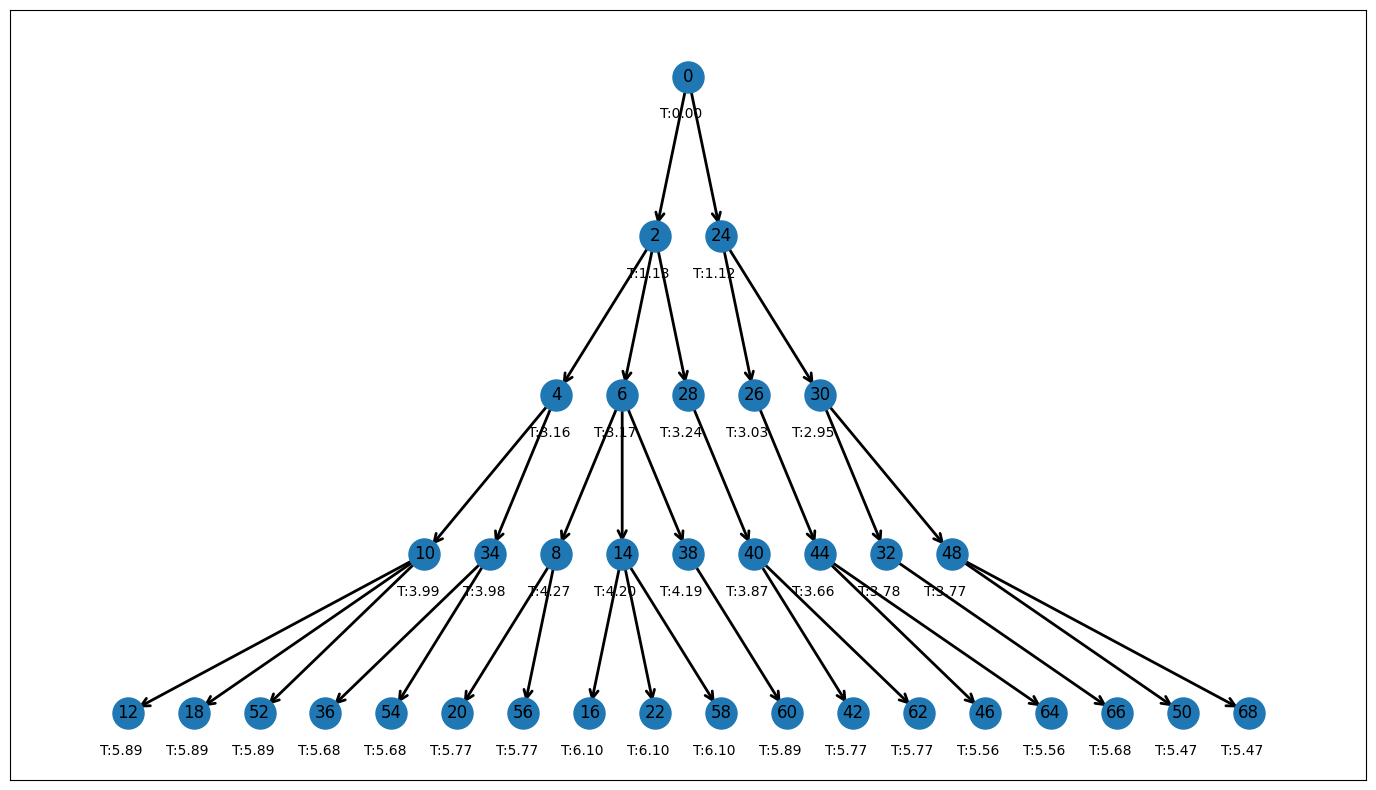

--------------------------Best Result: {'id': 50, 'total_time': 5.472792206135785, 'radius comb': [None, 3.0, 3.0, 3.0, None]}-------------------------------------


In [177]:
root.traverse()
draw_tree(root)
result = find_min_total_time_node_at_level(root,4)
print(f"--------------------------Best Result: {result}-------------------------------------")